In [ ]:
import cv2
import numpy as np

# Load image
img = cv2.imread("/content/frame_0561.jpg")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold to create mask (adjust value based on brightness)
_, mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Save the mask
cv2.imwrite("flashlight_mask.png", mask)


True

In [ ]:
# import cv2
# import numpy as np
# import os

# # Paths
# image_folder = "/content/drive/MyDrive/frames_output"   # change this
# mask_folder = "/content/drive/MyDrive/frames_output/frame_mask"     # output folder

# os.makedirs(mask_folder, exist_ok=True)

# # Loop through images
# for filename in os.listdir(image_folder):
#     if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
#         img_path = os.path.join(image_folder, filename)
#         img = cv2.imread(img_path)

#         # Convert to grayscale
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         # Threshold (tune value, e.g. 180–220 depending on brightness)
#         _, mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

#         # Clean noise with morphological ops
#         kernel = np.ones((5,5), np.uint8)
#         mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
#         mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

#         # Save mask
#         mask_filename = os.path.splitext(filename)[0] + "_mask.png"
#         cv2.imwrite(os.path.join(mask_folder, mask_filename), mask)

# print("✅ Masks created and saved in:", mask_folder)


✅ Masks created and saved in: /content/drive/MyDrive/frames_output/frame_mask


# Data Preparation:
Gather and Load Data: Obtain your image dataset (e.g., CIFAR-10, ## MNIST). Load it into your chosen deep learning framework (e.g., ## TensorFlow, PyTorch).
# Preprocessing:
Normalization: Scale pixel values to a common range (e.g., 0-1) for better training stability.
# Reshaping:
Ensure images have consistent dimensions and channel information (e.g., (height, width, channels)).
# Data Augmentation (Optional but Recommended):
Generate new training samples by applying transformations like rotations, flips, or zooms to increase dataset size and improve generalization.
# Split Data:
Divide your dataset into training, validation, and test sets.

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace(".jpg", "_mask.png")

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Paths
image_dir = "/content/drive/MyDrive/Flashlight_dataset/frames_output"
mask_dir  = "/content/drive/MyDrive/Flashlight_dataset/frame_mask"

# Transforms
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

dataset = SegmentationDataset(image_dir, mask_dir, transform)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=16, shuffle=False)

print(f"✅ Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


✅ Train: 541, Val: 67, Test: 69


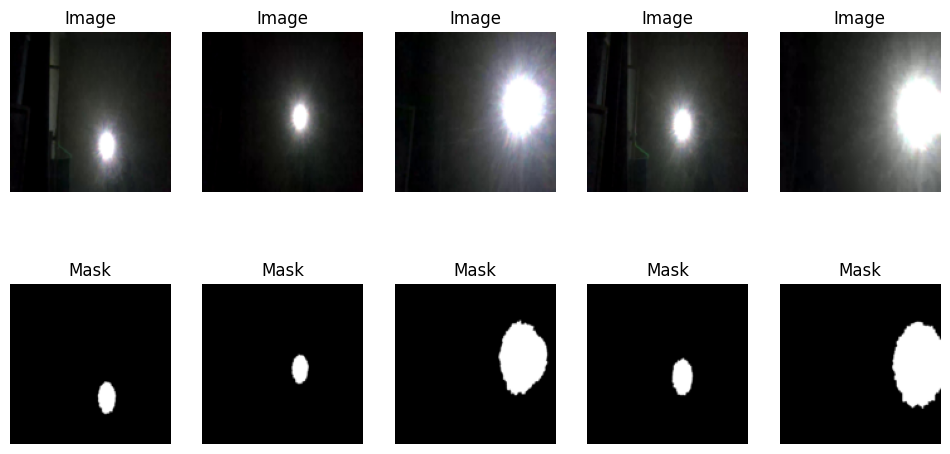

In [ ]:
import matplotlib.pyplot as plt

def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        image, mask = dataset[i]  # get sample
        image = image.permute(1, 2, 0).numpy()  # convert CHW → HWC
        mask = mask.squeeze().numpy()           # remove channel dim

        # plot
        plt.subplot(2, num_samples, i+1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    plt.show()

# Show some training samples
show_samples(train_set, num_samples=5)


# U Net

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# ------------------------------
# UNet Architecture
# ------------------------------
class DoubleConv(nn.Module):
    """(Conv2d => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5)
        x = self.conv1(torch.cat([x, x4], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x3], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x2], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x, x1], dim=1))
        logits = self.outc(x)
        return logits

# ------------------------------
# Model Compilation
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize UNet
model = UNet(n_channels=3, n_classes=1).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Loss function (binary segmentation)
criterion = nn.BCEWithLogitsLoss()

# Metrics (example IoU calculation)
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    intersection = (outputs & labels).sum((1,2,3))
    union = (outputs | labels).sum((1,2,3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

print("✅ UNet compiled with Adam optimizer, BCEWithLogitsLoss, and IoU metric.")



✅ UNet compiled with Adam optimizer, BCEWithLogitsLoss, and IoU metric.


# Seg Net

In [ ]:
def segnet_model(input_shape=(128,128,3)):
    inputs = layers.Input(input_shape)

    # Encoder
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Decoder
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)


In [ ]:
import torch
from tqdm import tqdm

# ------------------------------
# IoU Metric
# ------------------------------
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    outputs = torch.sigmoid(outputs) > threshold
    labels = labels > 0.5
    intersection = (outputs & labels).float().sum((1,2,3))
    union = (outputs | labels).float().sum((1,2,3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

# ------------------------------
# Dice Metric
# ------------------------------
def dice_score(outputs, labels, threshold=0.5, smooth=1e-6):
    outputs = torch.sigmoid(outputs) > threshold
    labels = labels > 0.5
    intersection = (outputs & labels).float().sum()
    return (2. * intersection + smooth) / (outputs.float().sum() + labels.float().sum() + smooth)

# ------------------------------
# Training Loop
# ------------------------------
def train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device="cuda"):
    model.to(device)
    history = {"train_loss": [], "val_loss": [], "val_iou": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, masks = images.to(device), masks.to(device)
            masks = masks.float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                masks = masks.float()

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_iou += iou_pytorch(outputs, masks).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_iou"].append(avg_val_iou)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val IoU: {avg_val_iou:.4f}")

    return model, history

# ------------------------------
# Evaluation Function
# ------------------------------
def evaluate_unet(model, test_loader, criterion, device="cuda"):
    model.eval()
    test_loss = 0.0
    total_iou, total_dice, total_acc = 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.float()

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5

            # IoU
            iou = iou_pytorch(outputs, masks).item()
            # Dice
            dice = dice_score(outputs, masks).item()
            # Pixel Accuracy
            acc = (preds == (masks > 0.5)).float().mean().item()

            total_iou += iou
            total_dice += dice
            total_acc += acc
            count += 1

    avg_loss = test_loss / count
    avg_iou = total_iou / count
    avg_dice = total_dice / count
    avg_acc = total_acc / count

    print(f"\n📊 Test Results:")
    print(f"Loss: {avg_loss:.4f}")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Dice: {avg_dice:.4f}")
    print(f"Accuracy: {avg_acc:.4f}")

    return {"loss": avg_loss, "iou": avg_iou, "dice": avg_dice, "accuracy": avg_acc}

# ------------------------------
# Example usage
# ------------------------------
model, history = train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)
results = evaluate_unet(model, test_loader, criterion, device=device)


Epoch 1/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]


Epoch [1/20] Train Loss: 0.2713 | Val Loss: 0.2543 | Val IoU: 0.9175


Epoch 2/20 - Training: 100%|██████████| 34/34 [00:18<00:00,  1.84it/s]


Epoch [2/20] Train Loss: 0.2477 | Val Loss: 0.2292 | Val IoU: 0.9270


Epoch 3/20 - Training: 100%|██████████| 34/34 [00:18<00:00,  1.88it/s]


Epoch [3/20] Train Loss: 0.2294 | Val Loss: 0.2231 | Val IoU: 0.8783


Epoch 4/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]


Epoch [4/20] Train Loss: 0.2136 | Val Loss: 0.1994 | Val IoU: 0.9387


Epoch 5/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.94it/s]


Epoch [5/20] Train Loss: 0.1972 | Val Loss: 0.1854 | Val IoU: 0.9484


Epoch 6/20 - Training: 100%|██████████| 34/34 [00:18<00:00,  1.88it/s]


Epoch [6/20] Train Loss: 0.1837 | Val Loss: 0.1745 | Val IoU: 0.9629


Epoch 7/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]


Epoch [7/20] Train Loss: 0.1725 | Val Loss: 0.1655 | Val IoU: 0.9652


Epoch 8/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]


Epoch [8/20] Train Loss: 0.1619 | Val Loss: 0.1499 | Val IoU: 0.9581


Epoch 9/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.93it/s]


Epoch [9/20] Train Loss: 0.1522 | Val Loss: 0.1446 | Val IoU: 0.9434


Epoch 10/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.94it/s]


Epoch [10/20] Train Loss: 0.1423 | Val Loss: 0.1361 | Val IoU: 0.9621


Epoch 11/20 - Training: 100%|██████████| 34/34 [00:18<00:00,  1.85it/s]


Epoch [11/20] Train Loss: 0.1343 | Val Loss: 0.1292 | Val IoU: 0.9450


Epoch 12/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.95it/s]


Epoch [12/20] Train Loss: 0.1267 | Val Loss: 0.1212 | Val IoU: 0.9662


Epoch 13/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.89it/s]


Epoch [13/20] Train Loss: 0.1190 | Val Loss: 0.1128 | Val IoU: 0.9666


Epoch 14/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]


Epoch [14/20] Train Loss: 0.1134 | Val Loss: 0.1085 | Val IoU: 0.9404


Epoch 15/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]


Epoch [15/20] Train Loss: 0.1069 | Val Loss: 0.1036 | Val IoU: 0.9636


Epoch 16/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.94it/s]


Epoch [16/20] Train Loss: 0.1003 | Val Loss: 0.0940 | Val IoU: 0.9682


Epoch 17/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]


Epoch [17/20] Train Loss: 0.0950 | Val Loss: 0.0914 | Val IoU: 0.9620


Epoch 18/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.97it/s]


Epoch [18/20] Train Loss: 0.0902 | Val Loss: 0.0872 | Val IoU: 0.9687


Epoch 19/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.94it/s]


Epoch [19/20] Train Loss: 0.0856 | Val Loss: 0.0828 | Val IoU: 0.9544


Epoch 20/20 - Training: 100%|██████████| 34/34 [00:17<00:00,  1.96it/s]


Epoch [20/20] Train Loss: 0.0810 | Val Loss: 0.0776 | Val IoU: 0.9674

📊 Test Results:
Loss: 0.0781
IoU: 0.9633
Dice: 0.9839
Accuracy: 0.9986


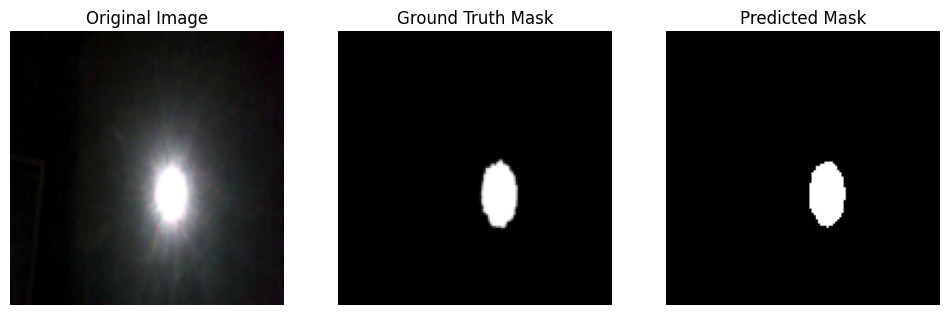

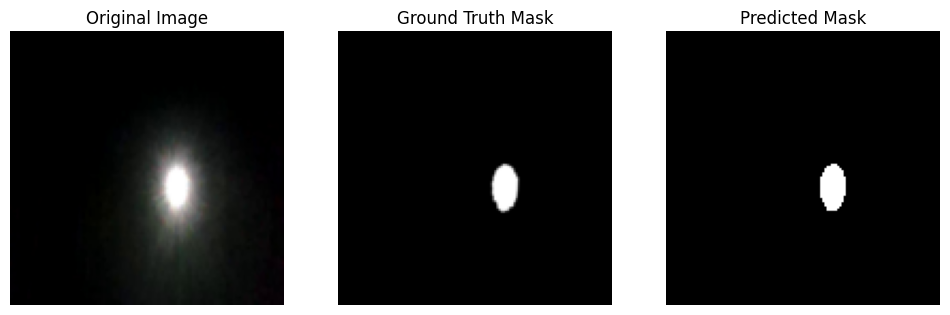

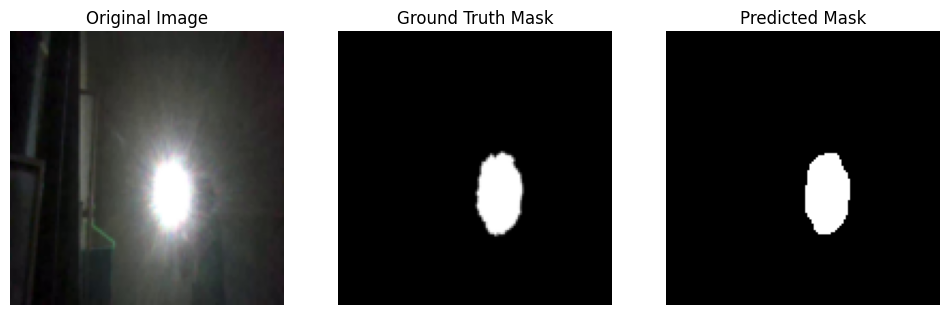

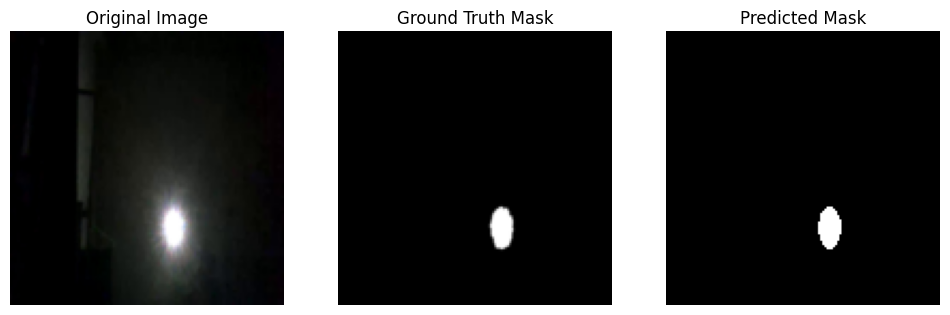

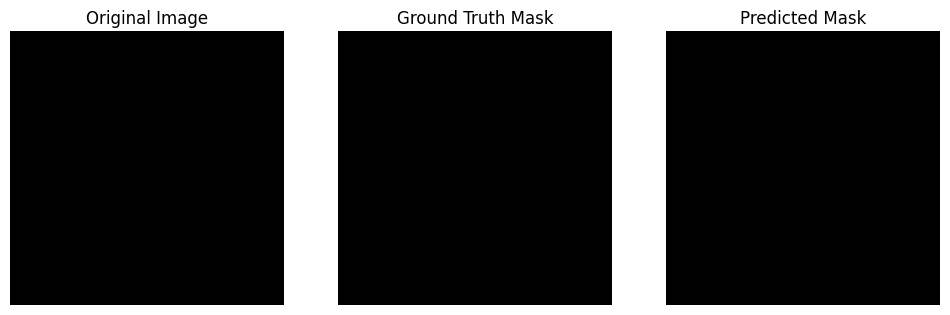

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, test_loader, device="cuda", num_images=5, threshold=0.5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images)) > threshold

            images = images.cpu()
            masks = masks.cpu()
            outputs = outputs.cpu()

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return

                img = images[i].permute(1,2,0)  # C,H,W -> H,W,C
                mask = masks[i].squeeze(0)      # 1,H,W -> H,W
                pred = outputs[i].squeeze(0)    # 1,H,W -> H,W

                fig, ax = plt.subplots(1,3, figsize=(12,4))
                ax[0].imshow(img)
                ax[0].set_title("Original Image")
                ax[0].axis("off")

                ax[1].imshow(mask, cmap="gray")
                ax[1].set_title("Ground Truth Mask")
                ax[1].axis("off")

                ax[2].imshow(pred, cmap="gray")
                ax[2].set_title("Predicted Mask")
                ax[2].axis("off")

                plt.show()
                images_shown += 1

# Usage:
visualize_predictions(model, test_loader, device=device, num_images=5)


In [ ]:
torch.save(model.state_dict(), "unet_flashlight.pth")
print("✅ Model weights saved as unet_flashlight.pth")

✅ Model weights saved as unet_flashlight.pth
